In [ ]:
!git clone https://github.com/pjreddie/darknet
!cd darknet
!make
!wget https://pjreddie.com/media/files/yolov3.weights 
!wget https://www.techsimplus.com/media/Screenshot_2020-06-13_at_7.41.41_AM.png
!mv /content/Screenshot_2020-06-13_at_7.41.41_AM.png /content/image.png
!apt-get -qq install -y libsm6 libxext6
!pip install -q -U opencv-python

Cloning into 'darknet'...
remote: Enumerating objects: 5907, done.
remote: Total 5907 (delta 0), reused 0 (delta 0), pack-reused 5907
Receiving objects: 100% (5907/5907), 6.32 MiB | 8.72 MiB/s, done.
Resolving deltas: 100% (3923/3923), done.
make: *** No targets specified and no makefile found.  Stop.
--2020-06-15 06:45:28--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   160KB/s    in 18m 53s 

2020-06-15 07:04:22 (214 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2020-06-15 07:04:24--  https://www.techsimplus.com/media/Screenshot_2020-06-13_at_7.41.41_AM.png
Resolving www.techsimplus.com (www.techsimplus.com)... 159.65.158.156
Connecting to www.techsimplus.com (ww

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [ ]:
labelsPath = "/content/darknet/data/coco.names"
Labels = open(labelsPath).read().strip().split("\n")

weightPath = "yolov3.weights"
configPath = "/content/darknet/cfg/yolov3.cfg"

Colors = np.random.randint(100, 255, (len(Labels), 3))

In [ ]:
net = cv2.dnn.readNetFromDarknet(configPath, weightPath)
image = cv2.imread("image.png")
H, W = image.shape[:2]

In [ ]:
layers = net.getLayerNames()
ucl = net.getUnconnectedOutLayers()
LayerName = []
for i in ucl:
    LayerName.append(layers[i[0]-1])

convertedImage = cv2.dnn.blobFromImage(image, 1/255, (416, 416), swapRB=True, crop=False)
net.setInput(convertedImage)
prediction = net.forward(LayerName)

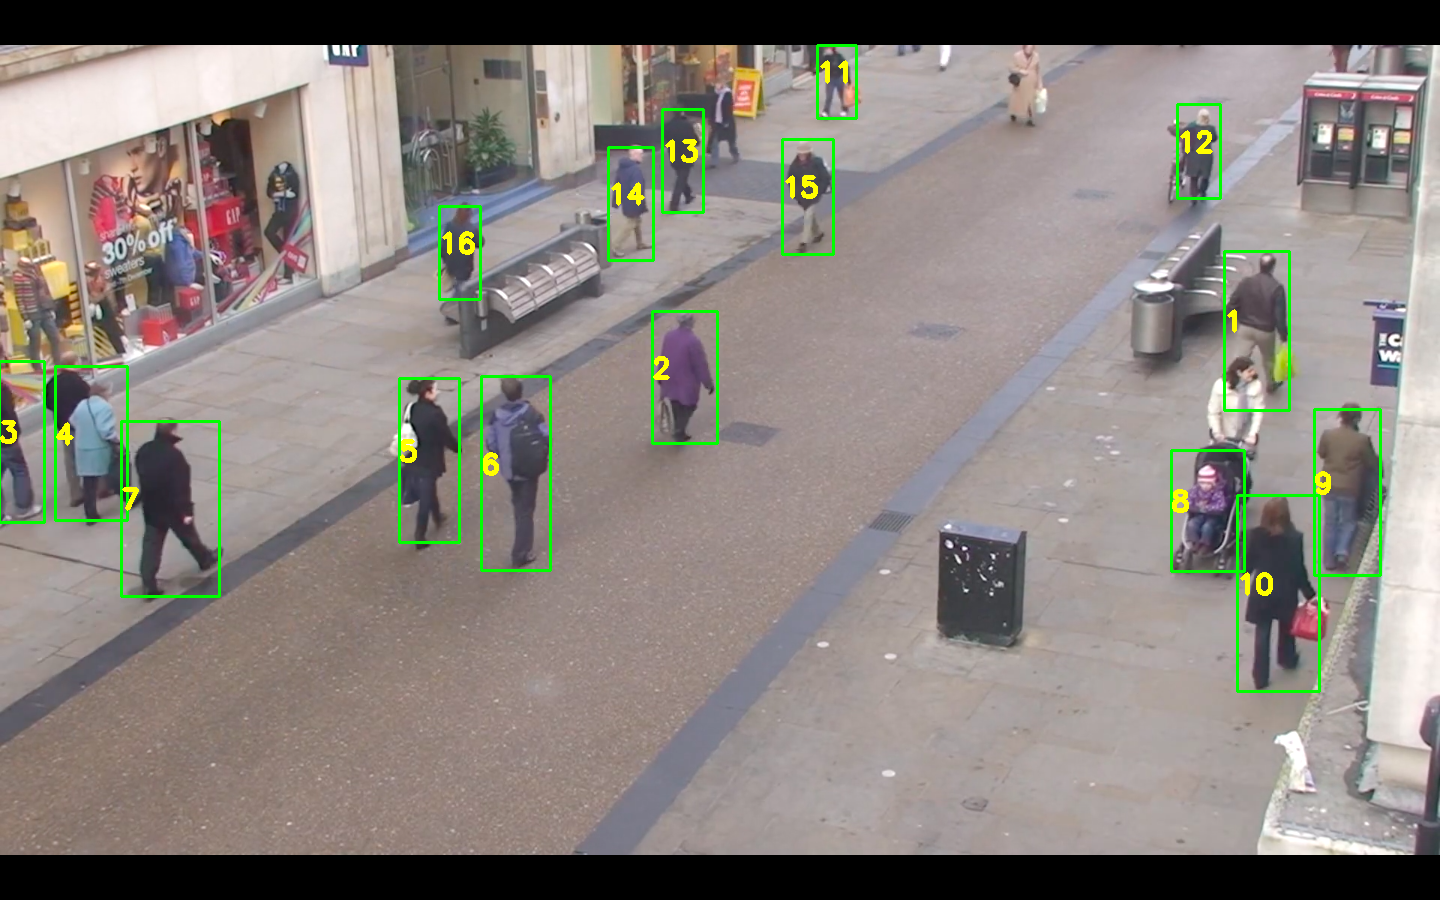

In [ ]:
X1 = []
X2 = []
Y1 = []
Y2 = []
Person = []
no_of_ppl = 0
xmid = []
ymid = []

for output in prediction:
    for detection in output:
        score = detection[5:]
        conf = np.max(score)
        classId = np.argmax(score)
        if Labels[classId] == "person":              #detecting person
          if conf > 0.85:                            #cheaking confidence is grater than 85%
              Cx,Cy,w,h = (detection[:4] * np.array([W,H,W,H])).astype("int")
              x = int(Cx - (w//2))
              y = int(Cy - (h//2))
              M = (x,y), (x+w, y+h)
              cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)          #drawing rectangle on identified person 
              no_of_ppl+=1
              cv2.putText(  image,str(no_of_ppl), (x,int(y+(h/2))), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,255), 3)    # alotting index no. to person

              
              #adding details to lists
              X1.append(x)
              Y1.append(y)
              X2.append(x+w)
              Y2.append(y+h)
              Person.append("person" + str(no_of_ppl))
              xmid.append(abs(x + (w/2)))
              ymid.append(abs(y + (h/2)))


#making DataFrame of all the collected data 
import pandas as pd
df = pd.DataFrame(list(zip(Person, X1, X2, Y1, Y2, xmid, ymid)), 
               columns =['person', 'x_1', 'x_2', 'y_1', 'y_2', 'x_mid', 'y_mid']) 
           
cv2_imshow(image)           #displaying resultant image


In [ ]:
df

,person,x_1,x_2,y_1,y_2,x_mid,y_mid
0,person1,1224,1289,251,410,1256.5,330.5
1,person2,652,717,311,443,684.5,377.0
2,person3,-1,44,361,522,21.5,441.5
3,person4,55,127,366,520,91.0,443.0
4,person5,399,459,378,542,429.0,460.0
5,person6,481,550,376,570,515.5,473.0
6,person7,121,219,421,596,170.0,508.5
7,person8,1171,1244,450,571,1207.5,510.5
8,person9,1314,1380,409,575,1347.0,492.0
9,person10,1237,1319,495,691,1278.0,593.0


In [ ]:
#caldulating distences between all the people 

flag = []
log = []
all_distances = []
xlen = len(df["x_2"])
for i in range(len(df["x_1"])):
  for j in range(i+1, xlen):
    distance = np.sqrt((df["x_mid"][i]-df["x_mid"][j])**2 + (df["y_mid"][i]-df["y_mid"][j])**2)  
    all_distances.append((distance, i+1 ,j+1))

    # finding the people crossing min. threshold distance
    if distance < 100:
      flag.append("person" + str(i+1))
      flag.append("person" + str(j+1))
      log.append((i+1,j+1)) 

all_distances   #distances between all the people

[(573.8869662224434, 1, 2),
 (1239.9782256152725, 1, 3),
 (1170.916948378492, 1, 4),
 (837.5717879680524, 1, 5),
 (754.5775308078024, 1, 6),
 (1100.984218778816, 1, 7),
 (186.5502613238588, 1, 8),
 (185.12833386599686, 1, 9),
 (263.37900447833727, 1, 10),
 (488.2632486681749, 1, 11),
 (188.63788060726299, 1, 12),
 (598.645136955108, 1, 13),
 (638.7526907966807, 1, 14),
 (468.569098426262, 1, 15),
 (800.807717245532, 1, 16),
 (666.1300548691675, 2, 3),
 (597.1584798024726, 2, 4),
 (268.6433509320489, 2, 5),
 (194.36306233438492, 2, 6),
 (531.0390757750318, 2, 7),
 (539.7696267853537, 2, 8),
 (672.4070567743917, 2, 9),
 (631.5839215812891, 2, 10),
 (332.3014444747419, 2, 11),
 (561.4908725883263, 2, 12),
 (216.50923767821087, 2, 13),
 (181.7092457746716, 2, 14),
 (218.42447207215588, 2, 15),
 (257.1483035137506, 2, 16),
 (69.51618516575834, 3, 4),
 (407.91972249451237, 3, 5),
 (495.00328281739706, 3, 6),
 (162.9148550623914, 3, 7),
 (1188.0054713678721, 3, 8),
 (1326.461646637399, 3, 9),

In [ ]:
flag = list(dict.fromkeys(flag))
flag   #group of people not following distancing

['person3', 'person4', 'person5', 'person6', 'person13', 'person14']

In [ ]:
doty = int(image.shape[0]-(image.shape[0]*0.9))
doty2 = int(image.shape[0]-(image.shape[0]*0.85))
dotx = int(image.shape[1]-(image.shape[1]*0.15))
center_g = (dotx, doty)
center_g_text = ((dotx + 20), (doty + 5))
center_r = (dotx, doty2)
center_r_text = ((dotx + 20), (doty2 + 5))


(900, 1440, 3) 1224 90


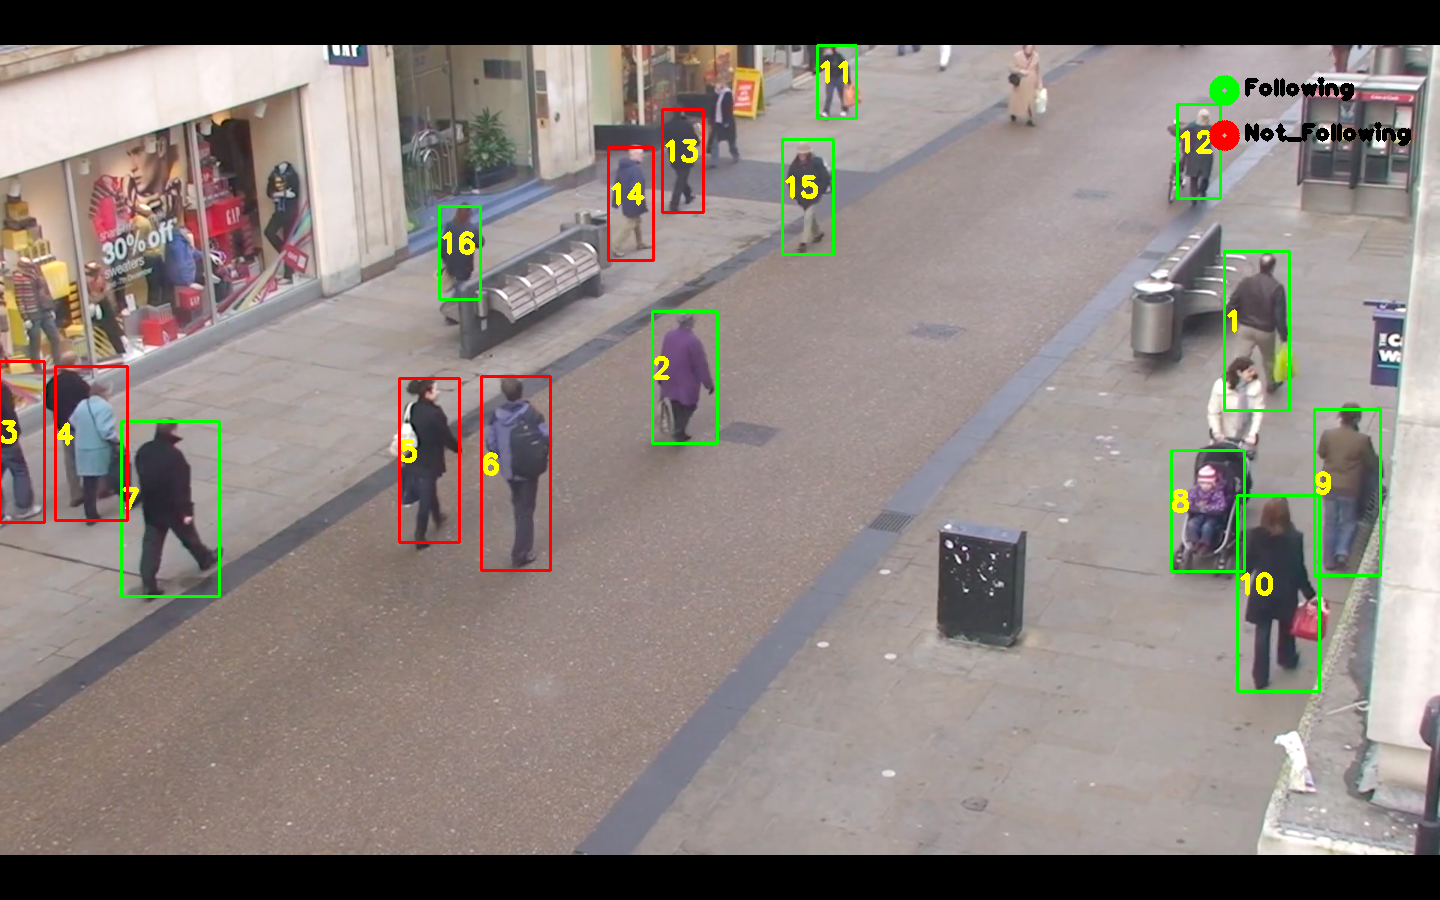

In [ ]:
#making the boxes around the people not following distances red in color
for i in range(len(flag)):
  for j in range(xlen):      
    if df["person"][j] == flag[i]:
      x_1 = df["x_1"][j]
      x_2 = df["x_2"][j]
      y_1 = df["y_1"][j]
      y_2 = df["y_2"][j]
      cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (0,0,255), 2)
    
cv2.circle(image, center_g, 9, (0, 255, 0), 12)                                                       # defining legend for green box
cv2.putText(  image,str("Following"), center_g_text , cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)    

cv2.circle(image, center_r, 9, (0, 0, 255), 11)                                                       # defining legend for red box
cv2.putText(  image,str("Not_Following"), center_r_text , cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), 3)    

cv2_imshow(image)
